## Code to compute the distance between clinical notes :
The distance is a weighted sum of all EMD per label. 
The EMD is computed similarly as https://nbviewer.org/github/vene/vene.github.io/blob/pelican/content/blog/word-movers-distance-in-python.ipynb
Inspired from the word mover distance
Hence the distance computed is basesd on the embeddings distance

EMD distance will be compare with the optimize linear sum assignement function https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html


### In this notebook, distance computation is done label by label
ie : Clustering on the cardiovascular label, infection label, immunitaire label etc... 


In [1]:
import os
import numpy as np
import pandas as pd 
import random
import pickle

import sklearn
from scipy.spatial.distance import cosine
from scipy.stats import hmean
from sklearn.metrics import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from tqdm import tqdm

import random

from pyemd import emd


# file_path = './out/16122021_train_local_annotated_without_neg_par_hyp_fasttext_BERT_embeddings.pkl'

file_path = './out/25012022_train_val_local_annotated_without_neg_par_hyp_Fasttext_BERT_Emb_Lower.pkl'
img_path = "./out/img_annot_all_attributes/"


Embedding = "Fasttext" # should be Fasttext of local_BERT or EDS_BERT
assert Embedding in ('Fasttext', 'local_BERT', 'EDS_BERT')


In [2]:
from easynmt import EasyNMT, models
# model = EasyNMT('opus-mt')
model_fr_en = EasyNMT(translator = models.AutoModel('../opus-mt-fr-en')) 

In [3]:
# load the dataframe
df = pd.read_pickle(file_path)
df['idx']=range(len(df))
# load the labels for all the terms of the file
labels = set(df['label'])
print('labels', labels)

# load the files 
files = set(df['source'])
# print("number of files", len(files))

labels {'nerveux', 'etatsosy', 'immunitaire', 'peau', 'respiratoire', 'cardiovasculaires', 'femme', 'infections', 'endocriniennes', 'nutritionnelles', 'homme', 'osteomusculaires', 'parasitaires', 'genetique', 'chimiques', 'stomatognathique', 'hemopathies', 'digestif', 'oeil', 'blessures', 'virales', 'tumeur', 'ORL'}


In [5]:
def flatten(t):
    return [item for sublist in t for item in sublist]


def distance_files_by_lab(file_1, file_2, Embedding, label, Distance_type = 'cosine', verbose = True) :
    """Compute a distance between two clinical notes, based on the embedding of their extracted terms, based on EMD distance
        Args :
        file_1 : name of the first file to compare 
        file_2 : name of the second files (corresponding to another patient or same patient at different time)
        Embedding : type of embedding should be Fasttext or local_BERT or EDS_BERT
        Distance_type : should be "cosine" ou "euclid"
        label : label we want to compute the distance on
        verbose : if True : print detailed information
        
        Outputs: 
        D_N : final distance 
    """

    
    if verbose:
        print(f'\n ----- Computing the distance between {file_1} and {file_2} for label {label}')
    # first get the common dataframe shared by the two files 
    df_reduc = df[(df["source"]== file_1) | (df["source"]== file_2)]
    # get the total number of terms 
    term_tot = len(df_reduc)
    
    # get the set of corresponding labels 
    labels = set(df_reduc['label'])
    if verbose: 
        print('Set of labels for the two patients', labels)
    

    df_patient_1 = df[df["source"]== file_1]
    df_patient_2 = df[df["source"]== file_2]
    
    labels_patient_1 = set(df_patient_1['label'])
    labels_patient_2 = set(df_patient_2['label'])
    
    # check if the label 
    labels_common = labels_patient_1.intersection(labels_patient_2)
  
    if label not in labels_common :
        print(f"this label {label} is not shared byt he two patients {file_1}, {file_2}")
        print("fonction will return a None object")
        return None

    # get the corresponding vocabulary of this label for the two files : 
    Vocab = df_reduc[df_reduc['label']== label]
    vocab_size = len(Vocab)
    if verbose :
        print(f'For the label "{label}", the vocabulary size is', vocab_size)
        
    # convert it to a dict readable for the CountVectorizer function 
    vocab_dict = {}
    j = 0
    for i in Vocab['idx']:
        if Vocab['term'][i] not in vocab_dict.keys():
            vocab_dict[Vocab['term'][i]] = j
            j += 1
        
    # get a representation feature 
    vect = CountVectorizer(vocabulary = vocab_dict, tokenizer = lambda x : [x], lowercase = False)# .fit([d1,d2,d3])
    # print("\n Features:\n","\n".join(vect.get_feature_names()))
        
    # get the terms for each file
    d1 = Vocab[Vocab['source']== file_1]
    term_1 = d1['term'].to_list()
    if verbose:
        print(f'\n terms patient 1 for label {label}\n', term_1)
    
    d2 = Vocab[Vocab['source']== file_2]
    term_2 = d2['term'].to_list()
    if verbose:
        print(f'\n terms patient 2 for label {label}\n', term_2)
    
    # get the corresponding histograms 
    v1_1 = vect.transform(term_1).toarray()
    v_1 = np.sum(v1_1, 0)
    v2_1 = vect.transform(term_2).toarray()
    v_2 = np.sum(v2_1, 0)
    
    # print(v_1, v_2)
    # print("\n cosine(doc_1, doc_2) = {:.2f}".format(cosine(v_1, v_2)))
    
    # get the FastText of BERT_embedding associated  
    idx_w = [Vocab[Vocab['term'] == w].iloc[0].idx for w in vect.get_feature_names()]
    W_2 = []

    for idx in idx_w:
        # print('\n------idx', idx)
        if (Embedding == 'Fasttext'): 
            W_2.append(Vocab['fastext_embeddings'][int(idx)])

        elif Embedding == "local_BERT": 
            W_2.append(Vocab['BERT_embeddings'][int(idx)])
                
    if Distance_type == 'cosine':
        Dist = sklearn.metrics.pairwise.cosine_distances(W_2) # cosine_distance : ie 1-cos similarity = 1-cos(theta)
    if Distance_type == 'euclid':
        Dist = euclidean_distances(W_2)
    
    # distance computation : 
    # pyemd needs double precision input
    v_1 = v_1.astype(np.double)
    v_2 = v_2.astype(np.double)
    
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()
    
    Dist = Dist.astype(np.double)
    if Dist.max() != 0:
        Dist /= Dist.max()  # just for comparison purposes
    D_EMD = emd(v_1, v_2, Dist)
    
             
    if verbose:
        print(f'\nDistance {Distance_type} for label {label} between {file_1} and {file_2} =',D_EMD)
    
    return D_EMD


    

In [16]:
# Main_2
# give the corresponding label :
label = "digestif"
# get the file containint the corresponding label : 
df_lab = df[df['label']==label]
files_lab = set(df_lab['source'])
files_lab_l = list(files_lab)

print(f"Computing the distance for label {label}")
# final dict of all distances : 
DIST_l = {}
count = 0

size_DIST = len(files_lab_l)**2
print('size_DIST', size_DIST)


for file_1 in sorted(files_lab):
    for file_2 in sorted(files_lab):
        if ((file_1,file_2) not in DIST_l.keys()) & ((file_2,file_1) not in DIST_l.keys()):
            D_EMD = distance_files_by_lab(file_1, file_2, Embedding,label,
                                          Distance_type = 'cosine', verbose = False)
            # print("D_EMD", D_EMD)
            DIST_l[(file_1,file_2)]= DIST_l[(file_2, file_1)] = D_EMD
            count += 1
            if count%1000 == 0:
                print('count', count)
        
            
            
            

Computing the distance for label digestif
size_DIST 7921
count 1000
count 2000
count 3000
count 4000


In [17]:
SCL = []
LUPUS = []
TAKA = []
SAPL = []

for i in range(len(files_lab_l)): 
    if 'scl' in files_lab_l[i]:
        SCL.append(files_lab_l[i])
    if 'lupus' in files_lab_l[i]:
        
        LUPUS.append(files_lab_l[i])
    if 'sapl' in files_lab_l[i]:
        SAPL.append(files_lab_l[i])
    if 'taka' in files_lab_l[i]:
        TAKA.append(files_lab_l[i])

dist_TAKA = [DIST_l[(f,g)] for f in TAKA for g in TAKA]
dist_SCL = [DIST_l[(f,g)] for f in SCL for g in SCL]
dist_LUPUS = [DIST_l[(f,g)] for f in LUPUS for g in LUPUS]
dist_SAPL = [DIST_l[(f,g)] for f in SAPL for g in SAPL]

np.mean(dist_TAKA), np.mean(dist_SCL), np.mean(dist_LUPUS), np.mean(dist_SAPL)

(0.8143820018999766,
 0.7231994525156995,
 0.8412200721766427,
 0.7272735558585414)

In [18]:
dist = [d for k,d in DIST_l.items()]
np.mean(dist)

0.8010687100602187

In [19]:
X = np.zeros((len(files_lab_l), len(files_lab_l)))

for i in range(len(files_lab_l)): 
    for j in range(len(files_lab_l)):
        X[i,j] = DIST_l[(files_lab_l[i],files_lab_l[j])]
       

# CLUSTERING 
from a Distance matrix : 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html


some other info on : 
https://stackoverflow.com/questions/18952587/use-distance-matrix-in-scipy-cluster-hierarchy-linkage

In [20]:
import scipy.cluster.hierarchy as hcl
from scipy.spatial.distance import squareform
import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(X) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

# hierarchical clustering encoded as a linkage matrix
Z = hcl.linkage(distArray, method = 'ward')

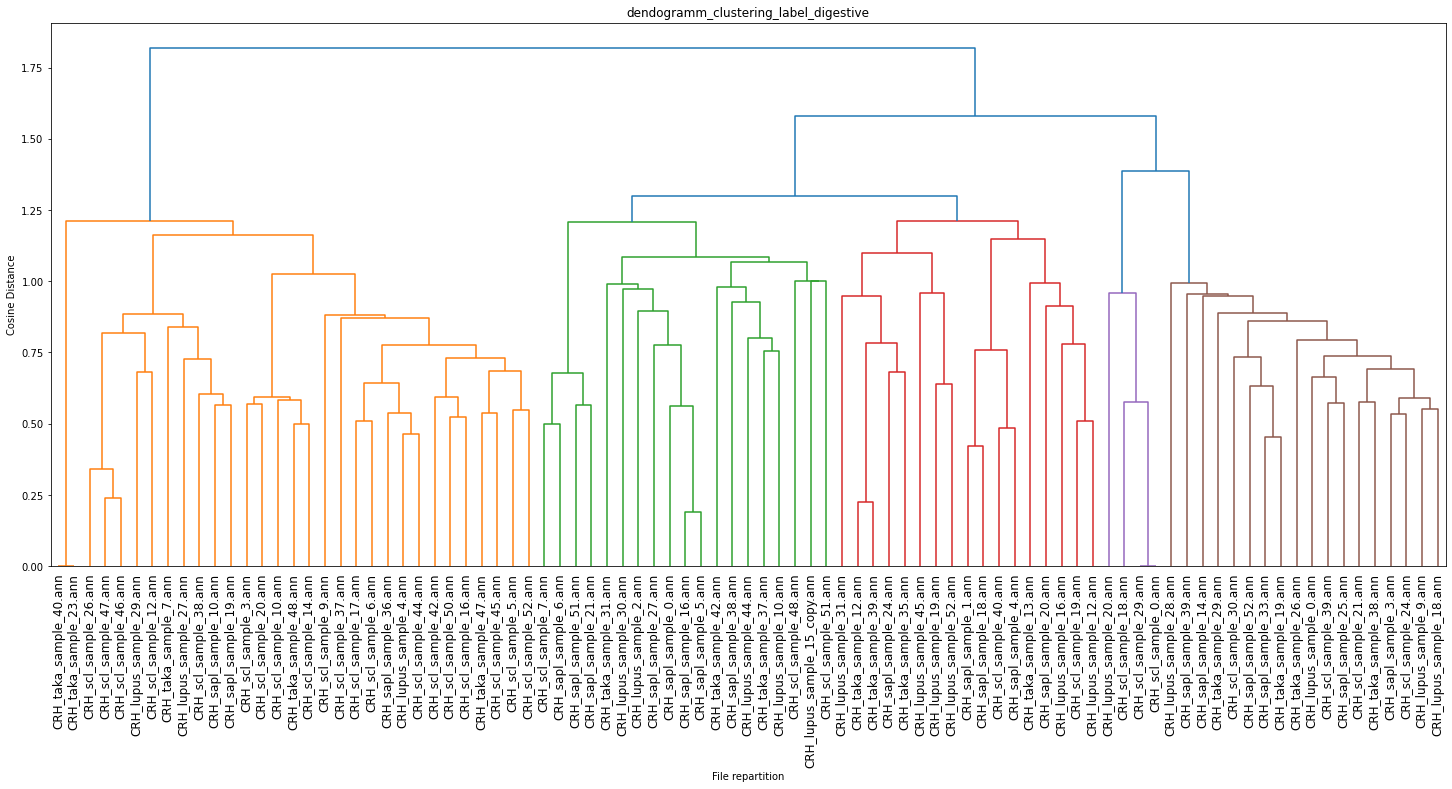

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

labels = files_lab_l

fig = plt.figure(figsize=(25, 10))

plt.title(f"dendogramm_clustering_label_digestive")
plt.xlabel('File repartition')
plt.ylabel('Cosine Distance')
dn = dendrogram(Z, labels = labels, leaf_rotation=90)
plt.xticks(fontsize=12,)
plt.savefig(f'{img_path}/dendrogram_clustering_label_digestive.pdf')


In [22]:
len(files_lab_l)

89

In [38]:
hcl_labels = hcl.fcluster(Z, t=1.4, criterion='distance')

In [39]:
# df.sample(5)
print(max(hcl_labels))

3


In [40]:
for i in range(len(labels)):
    idx = dn['leaves'][i]
    print(labels[idx],"\t Group :", hcl_labels[idx])
    print('TERMS')
    print(df_lab[df_lab["source"]==labels[idx]].term.tolist())

CRH_taka_sample_40.ann 	 Group : 1
TERMS
['gastrite a helicobacter pylori']
CRH_taka_sample_23.ann 	 Group : 1
TERMS
['gastrite a helicobacter pylori']
CRH_scl_sample_26.ann 	 Group : 1
TERMS
['polypose colique', 'oesophagite', "akinesie de l'oesophage", 'incontinence anale', "dilatation de l'oesophage stable", 'incontinence fecale secondaire', 'malabsorption', 'poic tres severe', 'pseudoobstruction intestinale', 'syndrome subocclusif traite par sonde nasogastrique et sandostatine avec une evolution favorable', 'distension du grele central', 'pullulation microbienne du grele', 'atteinte cardiaque digestive basse severe', 'pullulation microbienne', 'hernie hiatale', 'erosions de d2', 'dyssynergie abdominoperineale de type 1', 'sclerodermie systemique de forme cutanee diffuse avec atteinte severe notamment au plan cardiaque et digestif', 'syndrome subocclusif', 'hypotonie du muscle puborectal', 'aggravation des diarrhees', 'augmentation diarrhee', 'aggravation atteinte digestive avec aug

In [41]:
#from easynmt import EasyNMT, models
# model = EasyNMT('opus-mt')
# model_fr_en = EasyNMT(translator = models.AutoModel('opus-mt-fr-en')) 

In [42]:
dict_cluster_l = {}
size_group = {}
text_by_group = {}

for i in range(max(hcl_labels)):
    group_term = []
    size = 0
    for a,b in zip(files_lab_l, hcl_labels):
        if b==i+1:
            #print(f"{a}, group {b}")
            #print(df_lab[df_lab["source"]==a].term)
            translated_terms = model_fr_en.translate(df_lab[df_lab["source"]==a].term.tolist(), 
                                                     source_lang = 'fr',target_lang='en')
            group_term.append(translated_terms)
            dict_cluster_l[a] = b
            size += 1
    size_group[i] = size
    print(f"\n -- group {i}, with n = {size} elements")
    text_by_group[i] = ' '.join(flatten(group_term))




 -- group 0, with n = 31 elements

 -- group 1, with n = 36 elements

 -- group 2, with n = 22 elements


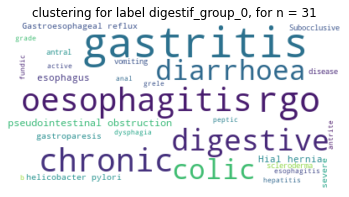

In [43]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

idx_group = 0


text = text_by_group[idx_group]
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["sur","du","en","le","les","par","clinique","de",'stabilité','au niveau',"gauche",'droite',"type",
                  'syndrome',"du", "et","amélioration", "diminution","majoration","stable", 'sévère',
                  "persistance", "bilatérale","maladie", "anti", "auto", 'de forme', 'la', "à", 
                  "des", "Ac","connue","au",'d',"atteinte", "non","avec", "l'hôpital", "est","aux", 'pour'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

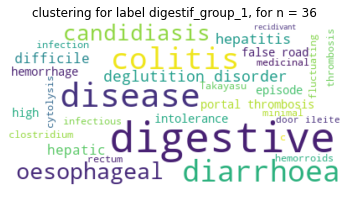

In [44]:
idx_group = 1
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

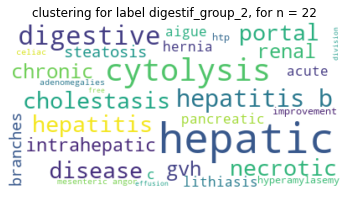

In [48]:
idx_group = 2
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

In [46]:
idx_group = 3
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

KeyError: 3

In [ ]:
idx_group = 4
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

In [118]:
idx_group = 5
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

KeyError: 5

In [ ]:
idx_group = 6
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

In [30]:
idx_group = 7
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

KeyError: 7

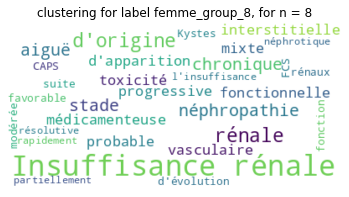

In [140]:
idx_group = 8
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

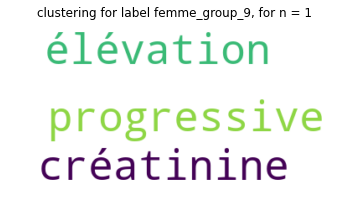

In [141]:
idx_group = 9
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

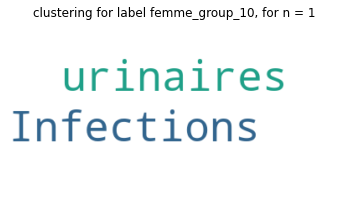

In [142]:
idx_group = 10
text = text_by_group[idx_group]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"clustering for label {label}_group_{idx_group}, for n = {size_group[idx_group]}")
plt.show()

# Save the image in the img folder:
wordcloud.to_file(f'{img_path}/wordcloud_annot_group_{idx_group}label_{label}.pdf')

In [72]:
for i in range(max(hcl_labels)):
    for a,b in zip(files_lab_l, hcl_labels):
        if b==i+1:
            print(f"{a}, group {b-1}")

CRH_scl_sample_42.ann, group 0
CRH_scl_sample_0.ann, group 0
CRH_scl_sample_29.ann, group 0
CRH_scl_sample_18.ann, group 0
CRH_sapl_sample_38.ann, group 0
CRH_lupus_sample_1.ann, group 0
CRH_scl_sample_7.ann, group 0
CRH_lupus_sample_8.ann, group 0
CRH_lupus_sample_27.ann, group 0
CRH_sapl_sample_27.ann, group 0
CRH_sapl_sample_14.ann, group 0
CRH_lupus_sample_28.ann, group 0
CRH_lupus_sample_23.ann, group 0
CRH_sapl_sample_1.ann, group 0
CRH_sapl_sample_21.ann, group 0
CRH_sapl_sample_39.ann, group 0
CRH_taka_sample_29.ann, group 1
CRH_lupus_sample_31.ann, group 1
CRH_taka_sample_20.ann, group 1
CRH_taka_sample_45.ann, group 1
CRH_taka_sample_26.ann, group 1
CRH_taka_sample_2.ann, group 1
CRH_taka_sample_40.ann, group 1
CRH_taka_sample_47.ann, group 1
CRH_taka_sample_7.ann, group 1
CRH_taka_sample_21.ann, group 1
CRH_taka_sample_5.ann, group 1
CRH_taka_sample_22.ann, group 1
CRH_taka_sample_16.ann, group 1
CRH_taka_sample_37.ann, group 1
CRH_taka_sample_19.ann, group 1
CRH_taka_sample

In [143]:
for i in range(max(hcl_labels)):
    for a,b in zip(files_lab_l, hcl_labels):
        if b==i+1:
            print(f"{a}, group {b}")
            print(df_lab[df_lab["source"]==a].term)

CRH_lupus_sample_3.ann, group 1
4496    protéinurie
Name: term, dtype: object
CRH_lupus_sample_18.ann, group 1
2800    protéinurie
2816    endométrite
Name: term, dtype: object
CRH_scl_sample_45.ann, group 1
7748    protéinurie
Name: term, dtype: object
CRH_taka_sample_5.ann, group 2
711    1 fausse couche
Name: term, dtype: object
CRH_lupus_sample_23.ann, group 2
9263    1 fausse couche
Name: term, dtype: object
CRH_lupus_sample_43.ann, group 3
10263       Endométriose
10272    atteinte rénale
10279       Métrorragies
10288         aménorrhée
Name: term, dtype: object
CRH_scl_sample_12.ann, group 3
519    Endométriose
Name: term, dtype: object
CRH_taka_sample_44.ann, group 4
9666    rupture prématurée des membranes
Name: term, dtype: object
CRH_scl_sample_5.ann, group 4
3877                      Colique néphretique
3886    3 fausses couches spontanées précoces
Name: term, dtype: object
CRH_lupus_sample_45.ann, group 4
8465    3 fausses couches spontanées précoces
8513                 